- 선택 종목 알맞는 K 값 찾는 볼랜드 밴드 전략 수익률 백테스팅
- 종목 자유 선택
- 매매 방식 
  + 매도 : 상단 돌파, 매수 : 하단 돌파, 나머진 보유
- 전략 적용과 단순 보유 수익 차이

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pykrx import stock


In [32]:
# 자산 A: KODEX 레버리지 (코스피200 레버리지 ETF)
kospiX2 = stock.get_market_ohlcv_by_date("20200101", "20241231", "122630")
kospiX2Close = kospiX2[['종가']]


# 자산 B: TIGER 코스닥150 선물인버스2X (코스닥150 선물 인버스2X ETF)
kosdaqInverseX2 = stock.get_market_ohlcv_by_date("20200101", "20241231", "251340")  # 종목코드 업데이트
kosdaqInverseX2Close = kosdaqInverseX2[['종가']]

In [33]:
kospiX2Close['2주(10영업일) 중심선'] = kospiX2Close['종가'].rolling(window=10).mean()
# kospiX2Close[9:50].head()
# kospiX2Close[9:50].tail()

/tmp/ipykernel_37508/1895954504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kospiX2Close['2주(10영업일) 중심선'] = kospiX2Close['종가'].rolling(window=10).mean()


In [34]:
stdDevi = kospiX2Close['종가'].rolling(window=10).std()
kospiX2Close['상단선'] = kospiX2Close['2주(10영업일) 중심선'] + 1 * stdDevi
kospiX2Close['하단선'] = kospiX2Close['2주(10영업일) 중심선'] - 1 * stdDevi
# kospiX2Close[9:50].head()

/tmp/ipykernel_37508/2730141237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kospiX2Close['상단선'] = kospiX2Close['2주(10영업일) 중심선'] + 1 * stdDevi
/tmp/ipykernel_37508/2730141237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kospiX2Close['하단선'] = kospiX2Close['2주(10영업일) 중심선'] - 1 * stdDevi


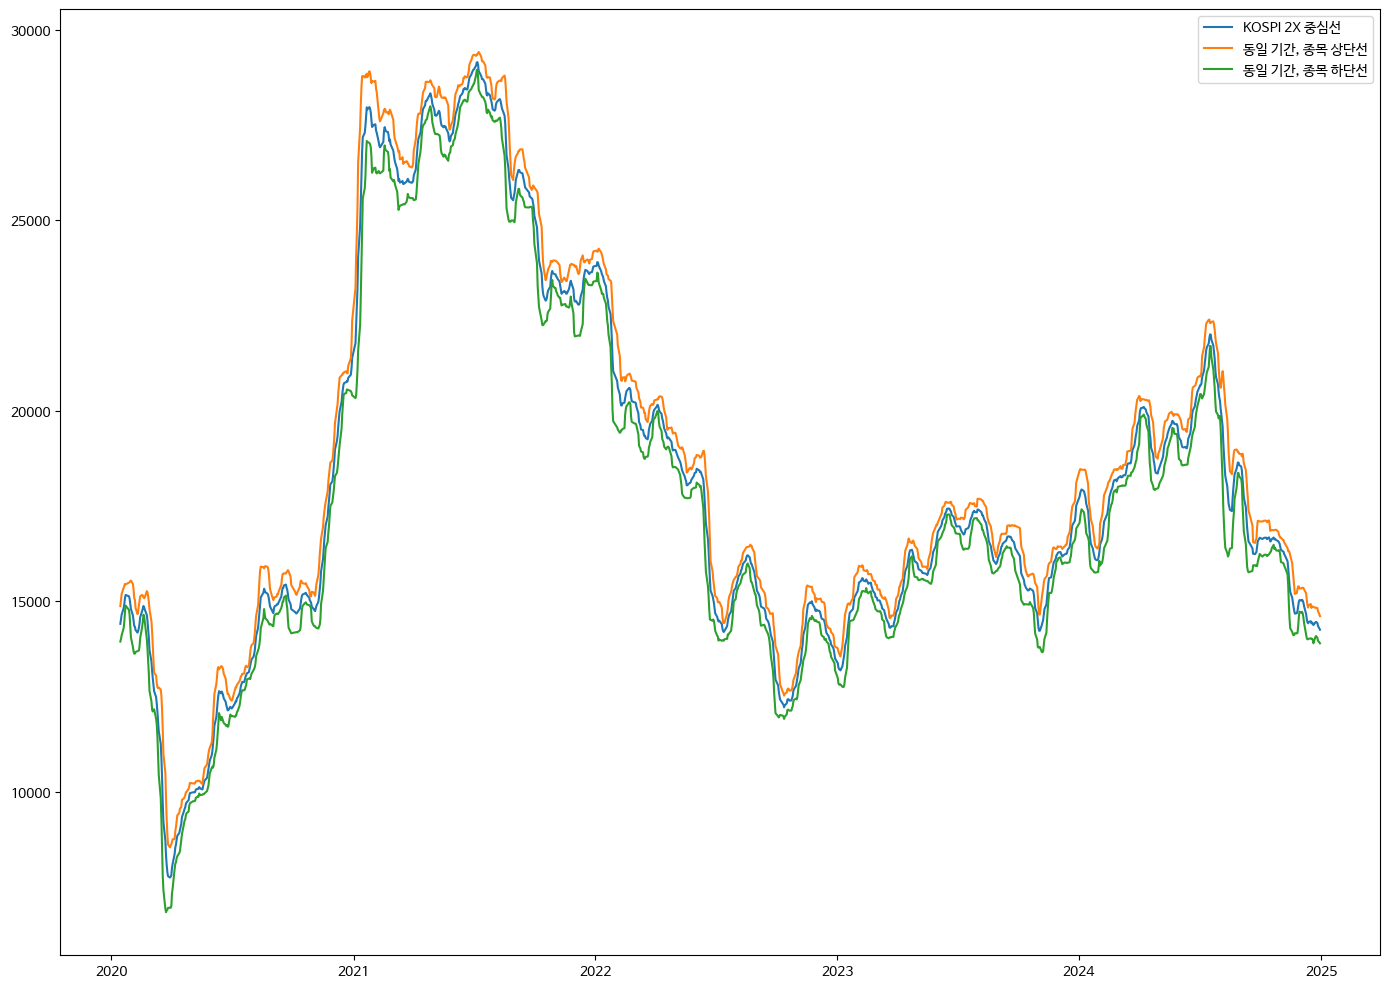

In [35]:

plt.figure(figsize=(14,10))

plt.plot(kospiX2Close['2주(10영업일) 중심선'][9:], label='KOSPI 2X 중심선')

plt.plot(kospiX2Close['상단선'][9:], label='동일 기간, 종목 상단선')

plt.plot(kospiX2Close['하단선'][9:], label='동일 기간, 종목 하단선')

plt.tight_layout()
plt.legend()
plt.show()

/tmp/ipykernel_37508/3314871763.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA'] = df['종가'].rolling(window=window).mean()
/tmp/ipykernel_37508/3314871763.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA'] = df['종가'].rolling(window=window).mean()
/tmp/ipykernel_37508/3314871763.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda


Inverse X2 거래 결과:
총 거래 횟수: 40
수익 거래: 20
승률: 50.0%
초기 자산: 100,000,000원
최종 자산: 45,706,791원
총 수익률: -54.29%
연평균 수익률(CAGR): -14.97%
투자 기간: 4.8년

X2 거래 결과:
총 거래 횟수: 46
수익 거래: 26
승률: 56.5%
초기 자산: 100,000,000원
최종 자산: 64,634,730원
총 수익률: -35.37%
연평균 수익률(CAGR): -8.52%
투자 기간: 4.9년


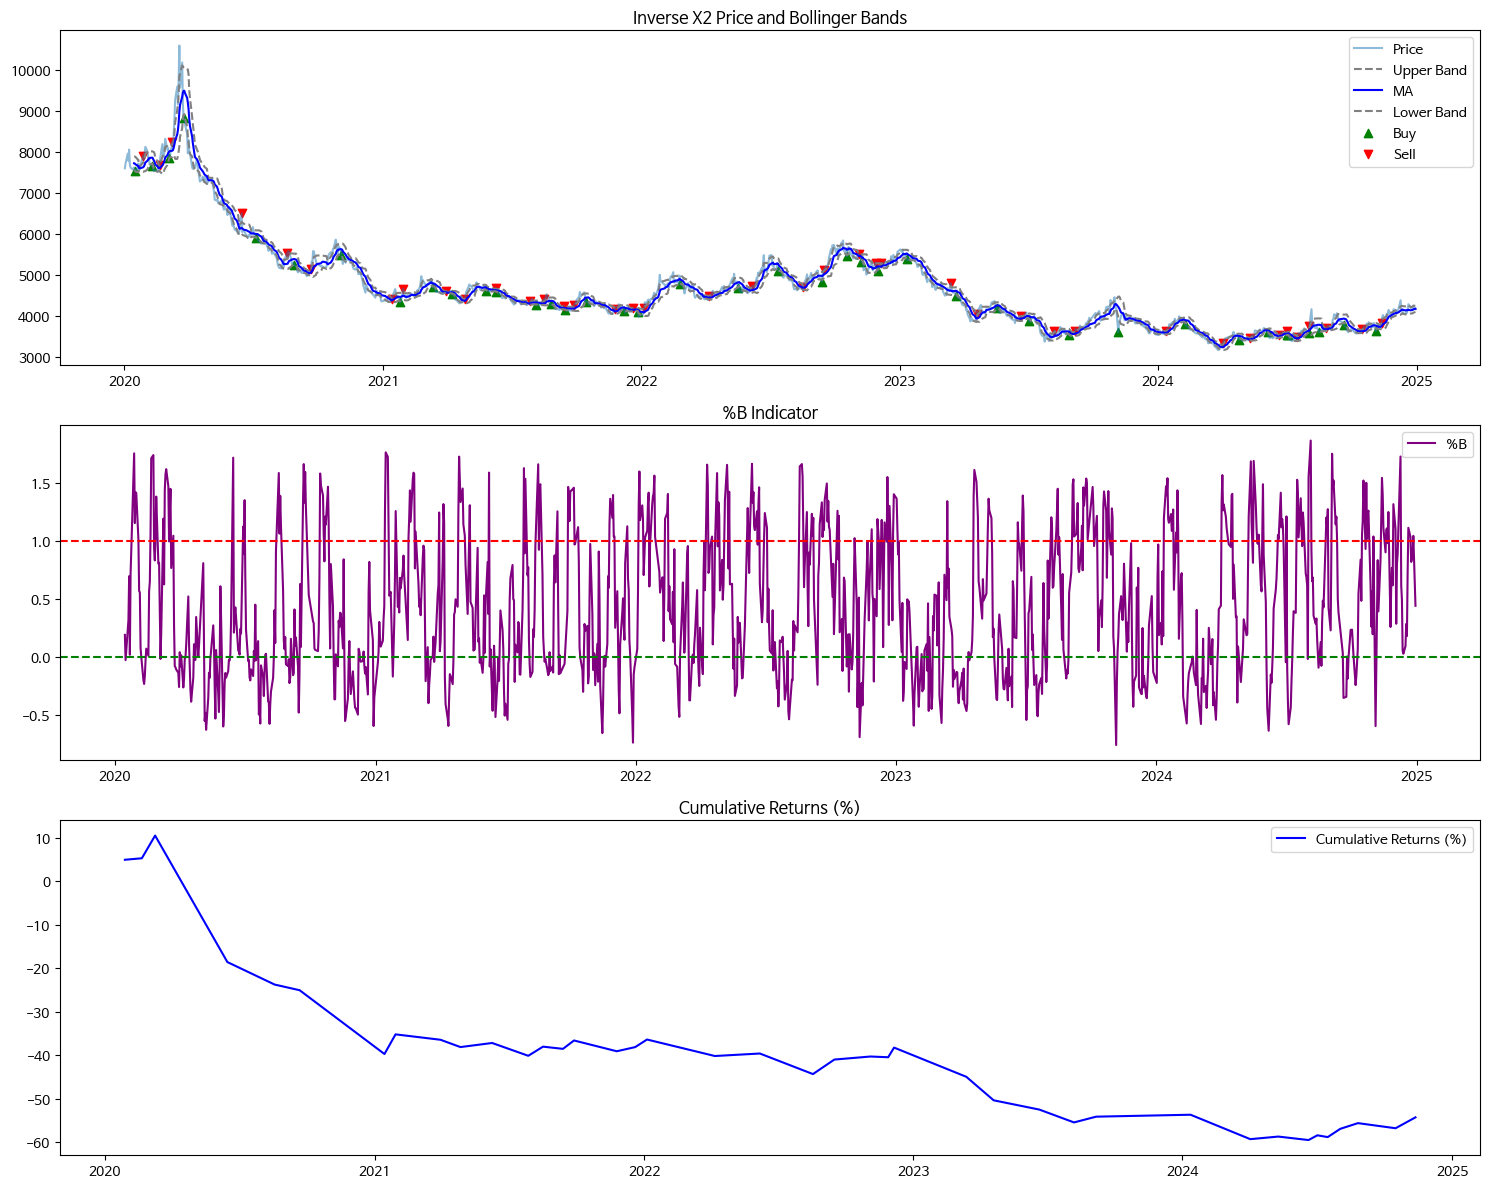

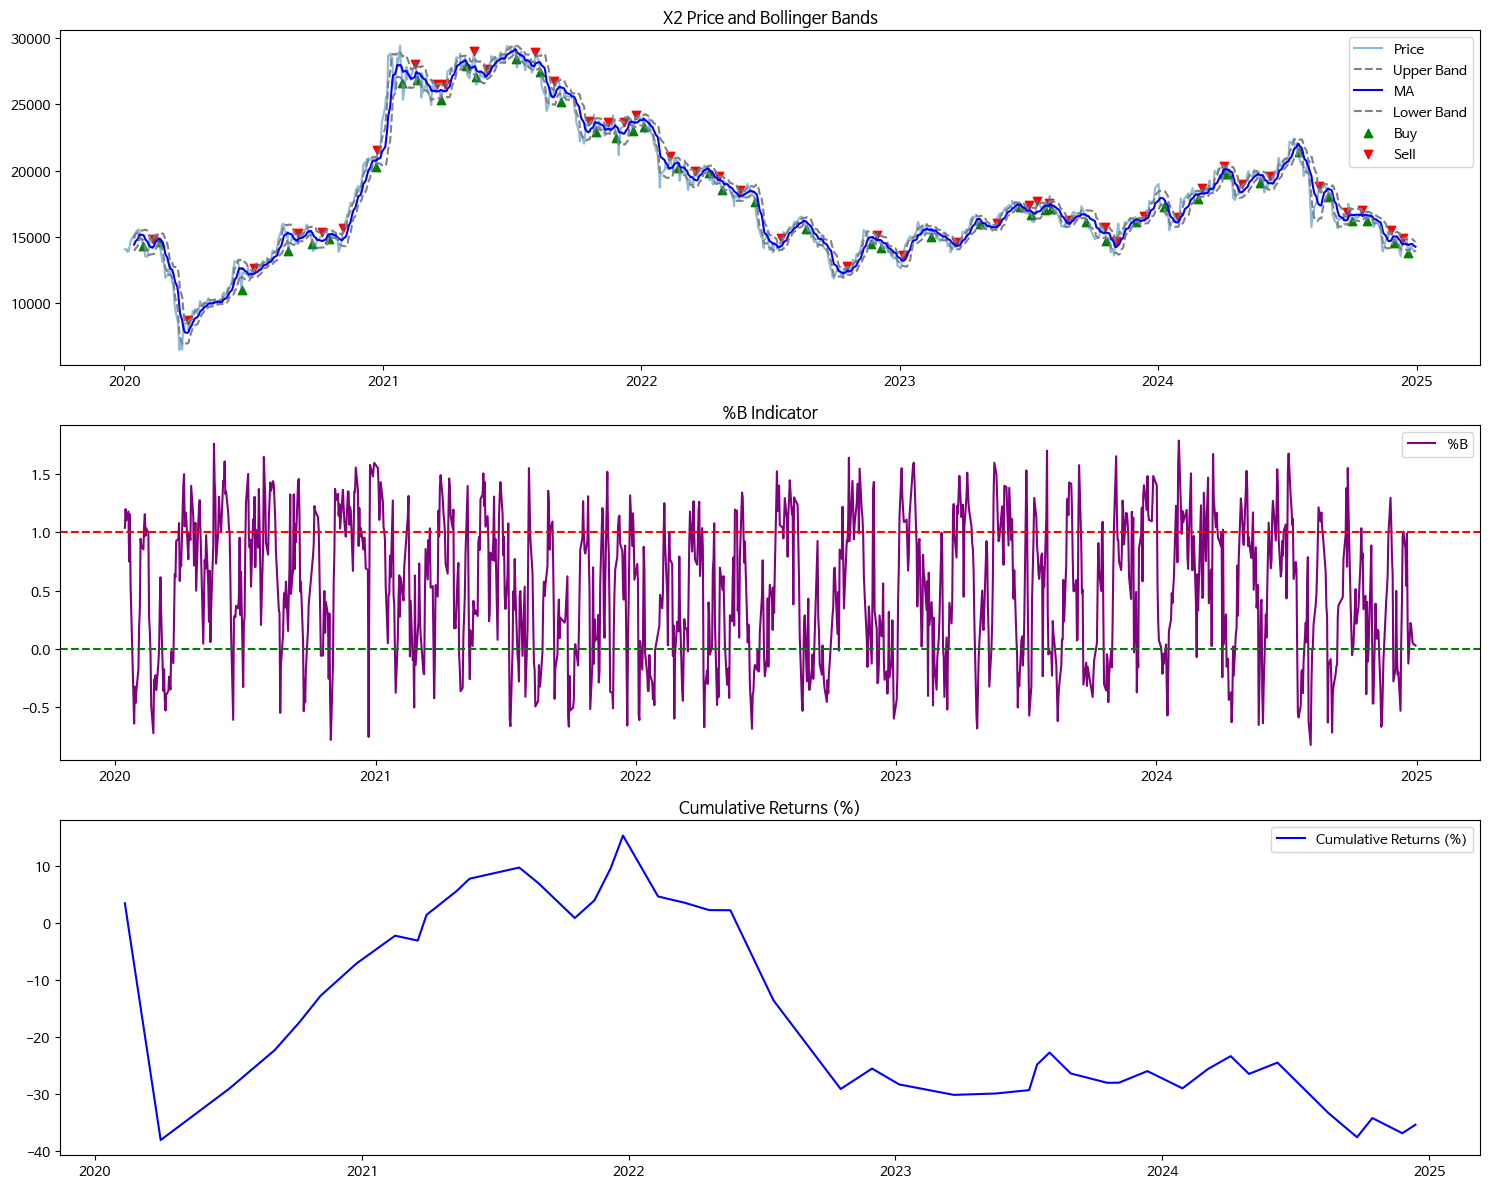

In [36]:
# 볼린저 밴드 계산
def calculate_bollinger_bands(df, window=10, num_std=1):
    """
    볼린저 밴드 계산
    - window: 이동평균 기간
    - num_std: 표준편차 승수
    """
    df['MA'] = df['종가'].rolling(window=window).mean()
    df['STD'] = df['종가'].rolling(window=window).std()
    df['Upper'] = df['MA'] + (df['STD'] * num_std)
    df['Lower'] = df['MA'] - (df['STD'] * num_std)
    
    # %B 지표 계산
    df['%B'] = (df['종가'] - df['Lower']) / (df['Upper'] - df['Lower'])
    
    return df

# 매매 신호 생성
def generate_signals(df):
    df['Signal'] = 0  # 0: 중립, 1: 매수, -1: 매도
    
    # %B < 0: 매수 (하단 밴드 아래로 내려갈 때)
    df.loc[df['%B'] < 0, 'Signal'] = 1
    
    # %B > 1: 매도 (상단 밴드 위로 올라갈 때)
    df.loc[df['%B'] > 1, 'Signal'] = -1
    
    return df

# 볼린저 밴드 계산 적용
kospiX2Close = calculate_bollinger_bands(kospiX2Close)

kosdaqInverseX2Close = calculate_bollinger_bands(kosdaqInverseX2Close)

# 매매 신호 적용
kospiX2Close = generate_signals(kospiX2Close)
kosdaqInverseX2Close = generate_signals(kosdaqInverseX2Close)

def backtest(df):
    position = 0  # 현재 포지션 (0: 없음, 1: 보유)
    trades = []  # 거래 기록
    entry_price = 0  # 매수 가격
    current_value = 100000000  # 초기 투자금 1억원
    highest_value = current_value  # 최고 자산가치
    
    for index, row in df.iterrows():
        if position == 0:  # 포지션이 없을 때
            if row['Signal'] == 1:  # 매수 신호
                position = 1
                entry_price = row['종가']
                shares = current_value / entry_price  # 매수 가능 주식 수
                trades.append({
                    'date': index,
                    'type': 'buy',
                    'price': row['종가'],
                    'bb_value': row['%B'],
                    'value': current_value
                })
        
        elif position == 1:  # 포지션 보유 중
            if row['Signal'] == -1:  # 매도 신호
                position = 0
                exit_price = row['종가']
                current_value = shares * exit_price
                highest_value = max(highest_value, current_value)
                
                trades.append({
                    'date': index,
                    'type': 'sell',
                    'price': row['종가'],
                    'profit': exit_price - entry_price,
                    'bb_value': row['%B'],
                    'value': current_value
                })
    
    # 마지막 거래가 매수이고, 마지막 시점의 시그널이 매도(-1)일 때만 청산
    if position == 1 and df['Signal'].iloc[-1] == -1:
        final_price = df['종가'].iloc[-1]
        current_value = shares * final_price
        trades.append({
            'date': df.index[-1],
            'type': 'sell',
            'price': final_price,
            'profit': final_price - entry_price,
            'bb_value': df['%B'].iloc[-1],
            'value': current_value
        })
    # 매수/보유 포지션 유지 중일 때는 현재가치만 업데이트
    elif position == 1:
        current_value = shares * df['종가'].iloc[-1]
    
    return trades, current_value


def calculate_cagr(initial_value, final_value, years):
    """
    CAGR(연평균 성장률) 계산
    """
    if initial_value > 0 and final_value > 0 and years > 0:
        cagr = (pow(final_value / initial_value, 1/years) - 1) * 100
        return cagr
    return 0

def print_trading_results(trades, name, initial_value=100000000):
    total_trades = len([t for t in trades if t['type'] == 'buy'])
    profitable_trades = len([t for t in trades if t['type'] == 'sell' and t['profit'] > 0])
    total_profit = sum([t['profit'] for t in trades if t['type'] == 'sell'])
    
    # 첫 거래와 마지막 거래 날짜
    first_trade_date = trades[0]['date']
    last_trade_date = trades[-1]['date']
    years = (last_trade_date - first_trade_date).days / 365
    
    # 최종 자산가치
    final_value = trades[-1]['value']
    
    # 총 수익률
    total_return = ((final_value - initial_value) / initial_value) * 100
    
    # CAGR 계산
    cagr = calculate_cagr(initial_value, final_value, years)
    
    print(f"\n{name} 거래 결과:")
    print(f"총 거래 횟수: {total_trades}")
    print(f"수익 거래: {profitable_trades}")
    print(f"승률: {(profitable_trades/total_trades*100):.1f}%")
    print(f"초기 자산: {initial_value:,.0f}원")
    print(f"최종 자산: {final_value:,.0f}원")
    print(f"총 수익률: {total_return:.2f}%")
    print(f"연평균 수익률(CAGR): {cagr:.2f}%")
    print(f"투자 기간: {years:.1f}년")


# 백테스팅 실행
inverse_x2_trades, inverse_x2_final_value = backtest(kosdaqInverseX2Close)
x2_trades, x2_final_value = backtest(kospiX2Close)

# 결과 출력
print_trading_results(inverse_x2_trades, "Inverse X2")
print_trading_results(x2_trades, "X2")

# 수익률 차트 추가
def plot_trades_with_returns(df, trades, title):
    plt.figure(figsize=(15, 12))
    
    # 가격과 볼린저 밴드 차트
    plt.subplot(3, 1, 1)
    plt.plot(df.index, df['종가'], label='Price', alpha=0.5)
    plt.plot(df.index, df['Upper'], label='Upper Band', color='gray', linestyle='--')
    plt.plot(df.index, df['MA'], label='MA', color='blue', linestyle='-')
    plt.plot(df.index, df['Lower'], label='Lower Band', color='gray', linestyle='--')
    
    # 매수/매도 포인트 표시
    buy_points = [(t['date'], t['price']) for t in trades if t['type'] == 'buy']
    sell_points = [(t['date'], t['price']) for t in trades if t['type'] == 'sell']
    
    if buy_points:
        buy_dates, buy_prices = zip(*buy_points)
        plt.scatter(buy_dates, buy_prices, color='g', marker='^', label='Buy')
    
    if sell_points:
        sell_dates, sell_prices = zip(*sell_points)
        plt.scatter(sell_dates, sell_prices, color='r', marker='v', label='Sell')
    
    plt.title(f'{title} Price and Bollinger Bands')
    plt.legend()
    
    # %B 차트
    plt.subplot(3, 1, 2)
    plt.plot(df.index, df['%B'], label='%B', color='purple')
    plt.axhline(y=1, color='r', linestyle='--')
    plt.axhline(y=0, color='g', linestyle='--')
    plt.title('%B Indicator')
    plt.legend()
    
    # 누적 수익률 차트
    plt.subplot(3, 1, 3)
    trade_values = [t['value'] for t in trades if t['type'] == 'sell']
    trade_dates = [t['date'] for t in trades if t['type'] == 'sell']
    
    if trade_values:
        returns = [(v/100000000 - 1) * 100 for v in trade_values]
        plt.plot(trade_dates, returns, label='Cumulative Returns (%)', color='blue')
        plt.title('Cumulative Returns (%)')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# 차트 그리기
plot_trades_with_returns(kosdaqInverseX2Close, inverse_x2_trades, 'Inverse X2')
plot_trades_with_returns(kospiX2Close, x2_trades, 'X2')


=== KOSDAQ Inverse X2 ===

Bollinger Band 전략 거래 결과:
총 거래 횟수: 40
수익 거래: 20
승률: 50.0%
초기 자산: 100,000,000원
최종 자산: 45,706,791원
총 수익률: -54.29%
연평균 수익률(CAGR): -14.97%
투자 기간: 4.8년

Buy & Hold 전략 결과:
초기 자산: 100,000,000원
최종 자산: 54,700,855원
총 수익률: -45.30%
연평균 수익률(CAGR): -11.37%
투자 기간: 5.0년

=== KOSPI X2 ===

Bollinger Band 전략 거래 결과:
총 거래 횟수: 46
수익 거래: 26
승률: 56.5%
초기 자산: 100,000,000원
최종 자산: 64,634,730원
총 수익률: -35.37%
연평균 수익률(CAGR): -8.52%
투자 기간: 4.9년

Buy & Hold 전략 결과:
초기 자산: 100,000,000원
최종 자산: 98,968,706원
총 수익률: -1.03%
연평균 수익률(CAGR): -0.21%
투자 기간: 5.0년


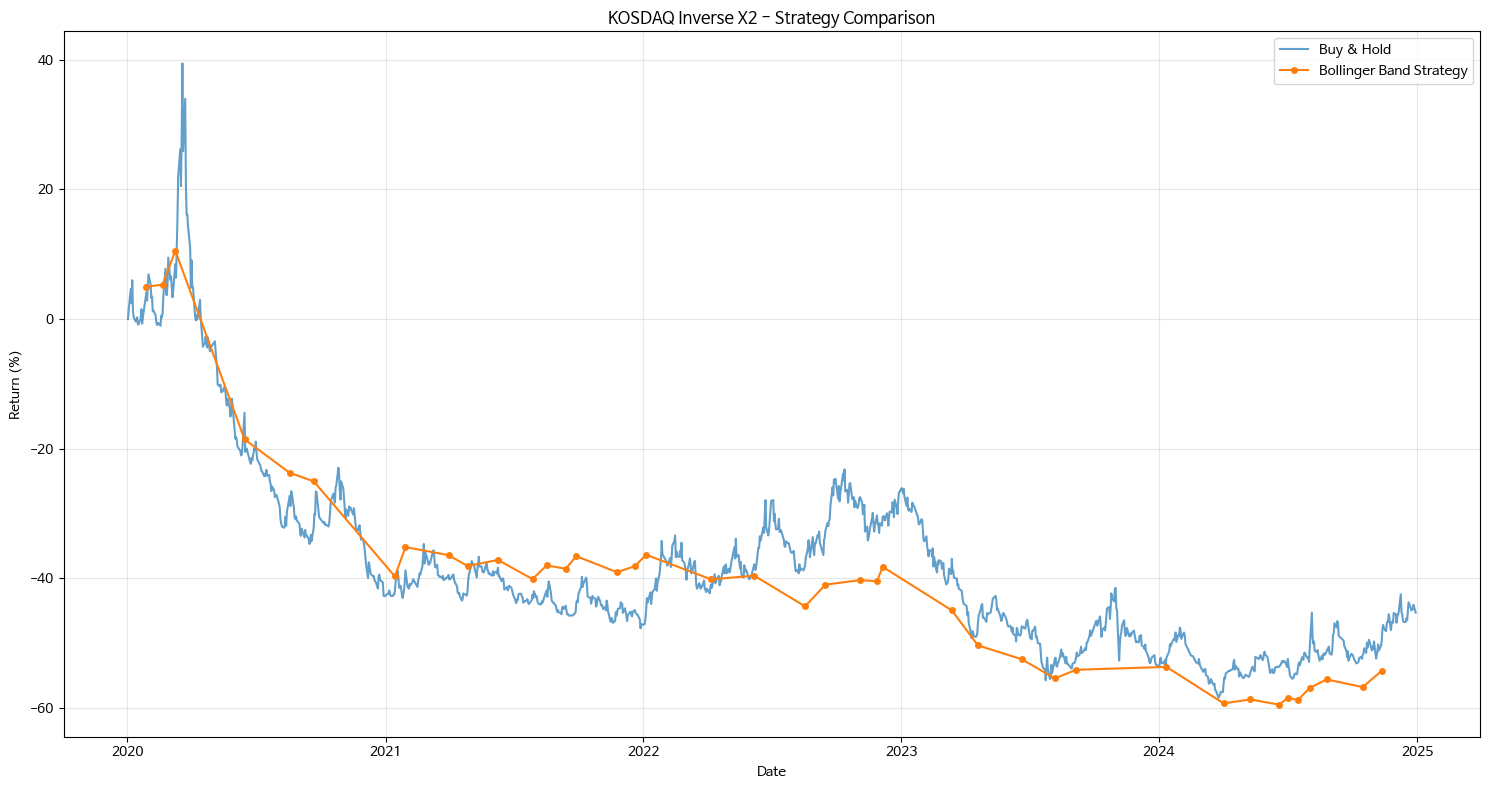

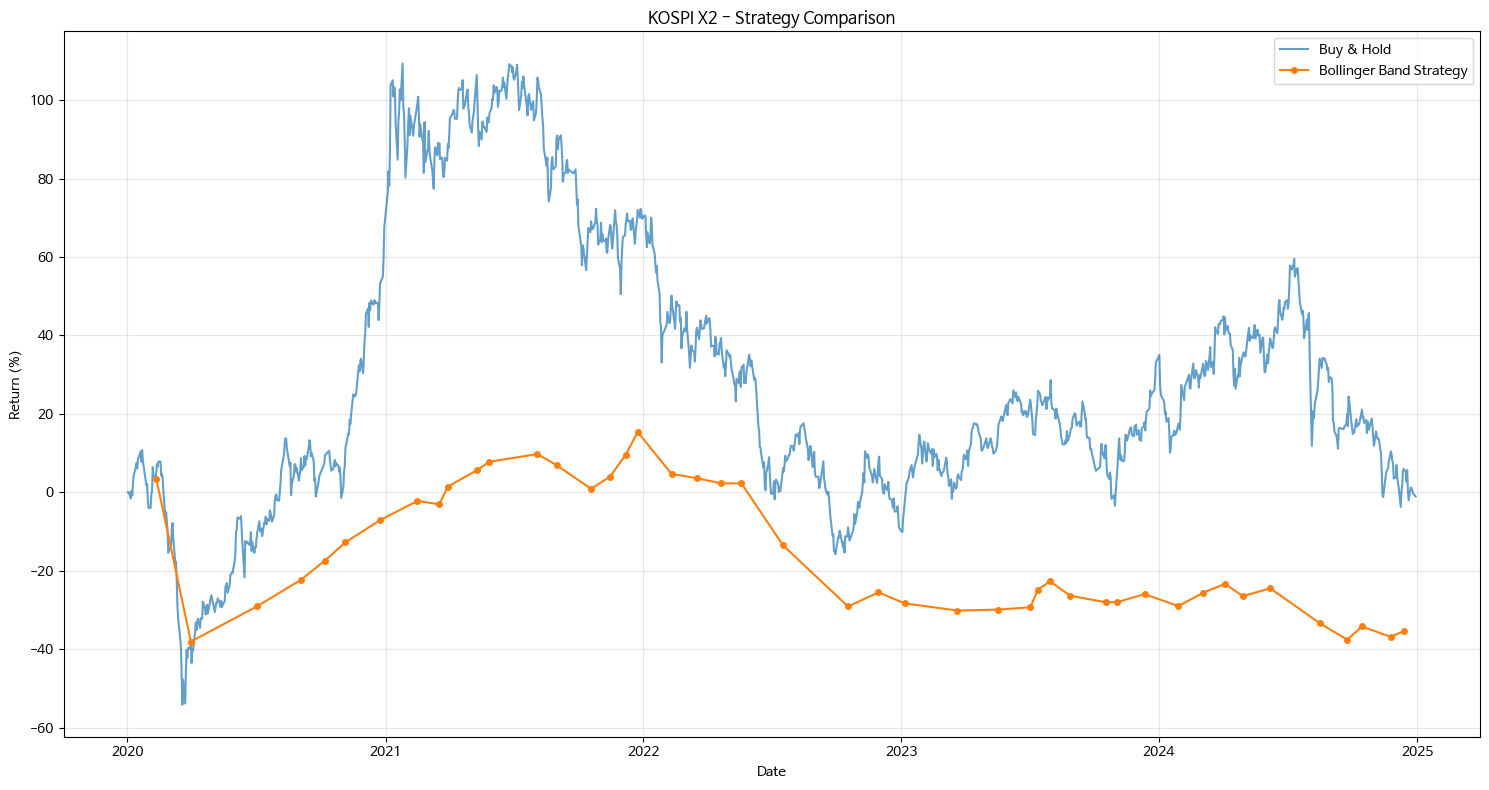

In [37]:
def calculate_buy_and_hold(df):
    initial_value = 100000000  # 초기 투자금 1억원
    initial_price = df['종가'].iloc[0]
    final_price = df['종가'].iloc[-1]
    
    shares = initial_value / initial_price
    final_value = shares * final_price
    total_return = ((final_value - initial_value) / initial_value) * 100
    
    # 투자 기간 계산
    years = (df.index[-1] - df.index[0]).days / 365
    cagr = calculate_cagr(initial_value, final_value, years)
    
    print("\nBuy & Hold 전략 결과:")
    print(f"초기 자산: {initial_value:,.0f}원")
    print(f"최종 자산: {final_value:,.0f}원")
    print(f"총 수익률: {total_return:.2f}%")
    print(f"연평균 수익률(CAGR): {cagr:.2f}%")
    print(f"투자 기간: {years:.1f}년")
    
    return final_value, total_return

# 각 전략별 결과 출력
print("\n=== KOSDAQ Inverse X2 ===")
print_trading_results(inverse_x2_trades, "Bollinger Band 전략")
bh_value_inverse, bh_return_inverse = calculate_buy_and_hold(kosdaqInverseX2Close)

print("\n=== KOSPI X2 ===")
print_trading_results(x2_trades, "Bollinger Band 전략")
bh_value_x2, bh_return_x2 = calculate_buy_and_hold(kospiX2Close)

# 전략 비교 시각화
def plot_strategy_comparison(df, trades, title):
    plt.figure(figsize=(15, 8))
    
    # Buy & Hold 수익률 계산
    initial_price = df['종가'].iloc[0]
    bh_returns = [(price/initial_price - 1) * 100 for price in df['종가']]
    
    # 볼린저 밴드 전략 수익률
    trade_values = [t['value'] for t in trades if t['type'] == 'sell']
    trade_dates = [t['date'] for t in trades if t['type'] == 'sell']
    
    if trade_values:
        strategy_returns = [(v/100000000 - 1) * 100 for v in trade_values]
        
        # 수익률 플롯
        plt.plot(df.index, bh_returns, label='Buy & Hold', alpha=0.7)
        plt.plot(trade_dates, strategy_returns, label='Bollinger Band Strategy', 
                marker='o', markersize=4)
        
        plt.title(f'{title} - Strategy Comparison')
        plt.xlabel('Date')
        plt.ylabel('Return (%)')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 전략 비교 차트 표시
plot_strategy_comparison(kosdaqInverseX2Close, inverse_x2_trades, 'KOSDAQ Inverse X2')
plot_strategy_comparison(kospiX2Close, x2_trades, 'KOSPI X2')
